<a href="https://colab.research.google.com/github/americanthinker/vectorsearch-applications/blob/main/1-Data_Preprocessing_Week1_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 1: Vector Search Applications w/ LLMs.  Authored by Chris Sanchez.

# Week 1 - Notebook 1

# Overview
<div class="alert alert-danger"><h5>If you haven't already, make sure you first read the pre-course material (Week 0) before attempting this notebook: <a href="https://uplimit.com/course/vector-search-apps/v2/enrollment/enrollment_clnnpb75t000j1aabfiqp1p9p/module/information-retrieval">See here</a></h5></div>
We will divide the approach to building our system into four parts over two weeks-

#### Week One
* Part 1 **(THIS NOTEBOOK)**:
  * Data ingest and preprocessing
  * Convert text into vectors
* Part 2:
  * Index data on Weaviate database
  * Search over data
* Part 2.5:
  * Benchmark retrieval results

#### Week Two
* Part 3:
  * Add a reranker to the mix (new benchmark)
  * Integrate with GPT-Turbo
* Part 4:
  * Display results in Streamlit


#### This notebook will cover the highlighted portion of the technical diagram below, as initially referenced in the Course content:

![arch_diagram]( 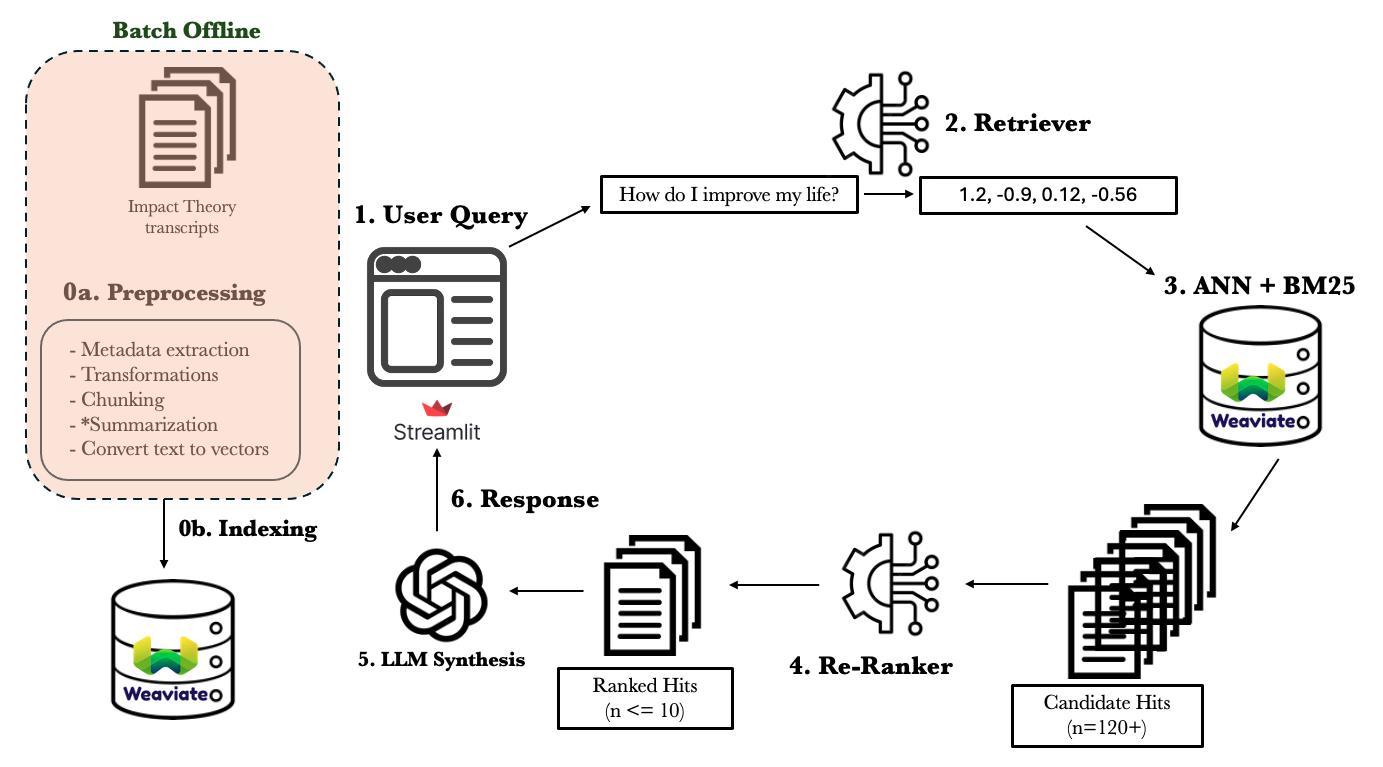)

Specifically, the assignments in this notebook will address:
- Splitting episode transcripts into text chunks
- Creating a vector embedding for each text chunk
- Performing a few minor data transformations
- Adding metadata to each text chunk and embedding

\*Episode summaries have already been generated for each episode and are included as part of the episode metadata

<div class="alert alert-danger"><h5>The following four code cells assume you running this notebook in Goolge Colab</h5></div>

## Install libraries for this notebook

In [1]:
#visualization tool for displaying long load/processing times
!pip install tqdm --quiet
#data processing
!pip install pandas --quiet
#workhorse for converting text into embeddings/vectors
!pip install sentence-transformers==2.2.2 --quiet
#data framework for LLM applications
!pip install llama-index==0.9.6.post1 --quiet
#logging output
!pip install loguru==0.7.0 --quiet
#convenient pretty printing library
!pip install rich==13.7.0 --quiet
#openai Tokenizer library
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.4/896.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account 

## Download preprocessing file (helper code) from Github repo

In [2]:
!curl -o preprocessing.py https://raw.githubusercontent.com/americanthinker/vectorsearch-applications/main/preprocessing.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4625  100  4625    0     0  15254      0 --:--:-- --:--:-- --:--:-- 15264


In [3]:
!curl -o unitesting_utils.py https://raw.githubusercontent.com/americanthinker/vectorsearch-applications/main/unitesting_utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1495  100  1495    0     0   5995      0 --:--:-- --:--:-- --:--:--  6004


## Download data from Github repo
Total download size should be about 25 MB

In [4]:
!curl -o impact_theory_data.json https://raw.githubusercontent.com/americanthinker/vectorsearch-applications/main/data/impact_theory_data.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.6M  100 25.6M    0     0  29.6M      0 --:--:-- --:--:-- --:--:-- 29.6M


In [5]:
#standard libraries
import json
import os
import time
from collections import defaultdict
from typing import List, Dict, Tuple, Union, Callable
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from rich import print
from torch import cuda
from tqdm.notebook import tqdm

#external files
from preprocessing import FileIO

## Step 1 -->  Import YouTube/Podcast Transcripts
***

### The Data
The data - **384** podcast episodes to be exact - we will use for this project is a collection of transcribed podcast/youtube episodes of <a href="https://www.youtube.com/@TomBilyeu" target="_blank">The Impact Theory</a>.  From the About section of Impact Theory:
<h4 style='text-align: center;'><em>"Impact Theory™ is a weekly interview show that explores the mindsets of the world's highest achievers to learn their secrets to success.</em></h4>
<h4 style='text-align: center;'><em>Hosted by Quest Nutrition co-founder Tom Bilyeu, Impact Theory is designed to give people the tools and knowledge they need to unlock their potential and impact the world."</em></h4>
<br>

![YouTube Playlist]( 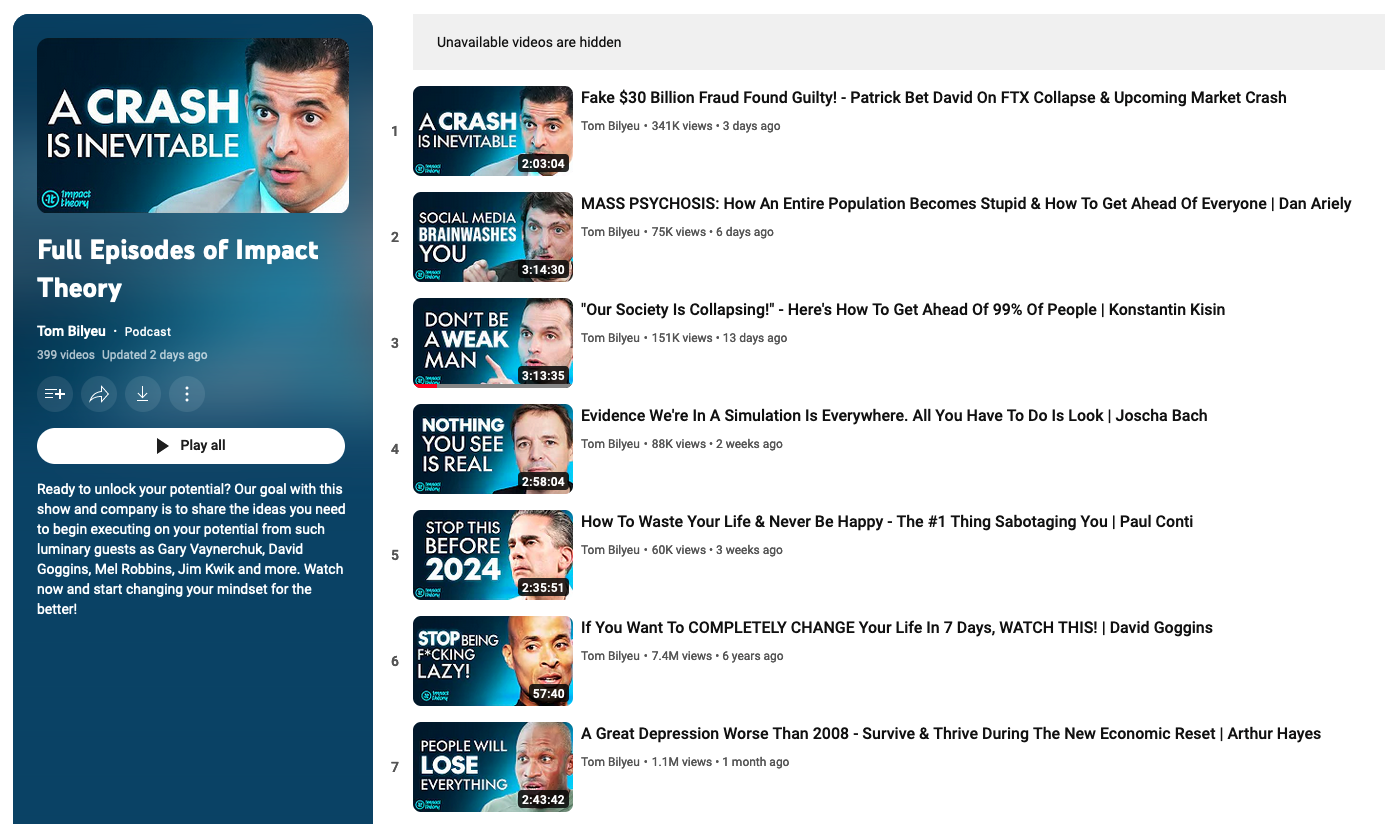)

Throughout this course I will refer to the data as "YouTube" episodes or "podcast" episodes.  The reason for this is that the show is setup like a podcast and is released as a podcast, but it's also available on YouTube.  The episodes for this course were pulled from the podcast audio files and transcribed using the OpenAI open source [Whisper model](https://github.com/openai/whisper).  The transcriptions were then linked back to each episode using a unique **video_id**.  

### Import Data

Assuming you've already downloaded the data from the course repo, follow the instructions below to import the data and make it available in this notebook's namespace.
  
<div class="alert alert-danger"><h5>If you are not running this notebook on Colab, you'll need to readjust your data filepaths.</h5></div>

In [6]:
#root folder on Google Colab is: /content/
root_folder = '/content/'
data_file = 'impact_theory_data.json'
data_path = os.path.join(root_folder, data_file)
data_path

'/content/impact_theory_data.json'

You should see 384 unique podcast entries, imported as a list of dictionaries, with each dictionary being a single episode.

In [7]:
with open(data_path) as f:
    data =  json.load(f)
print(f'Total # of episodes: {len(data)}')

Total # of episodes: 384

### Data Review

Upon import, below is an example of what a single episode should look like:

![data example]( 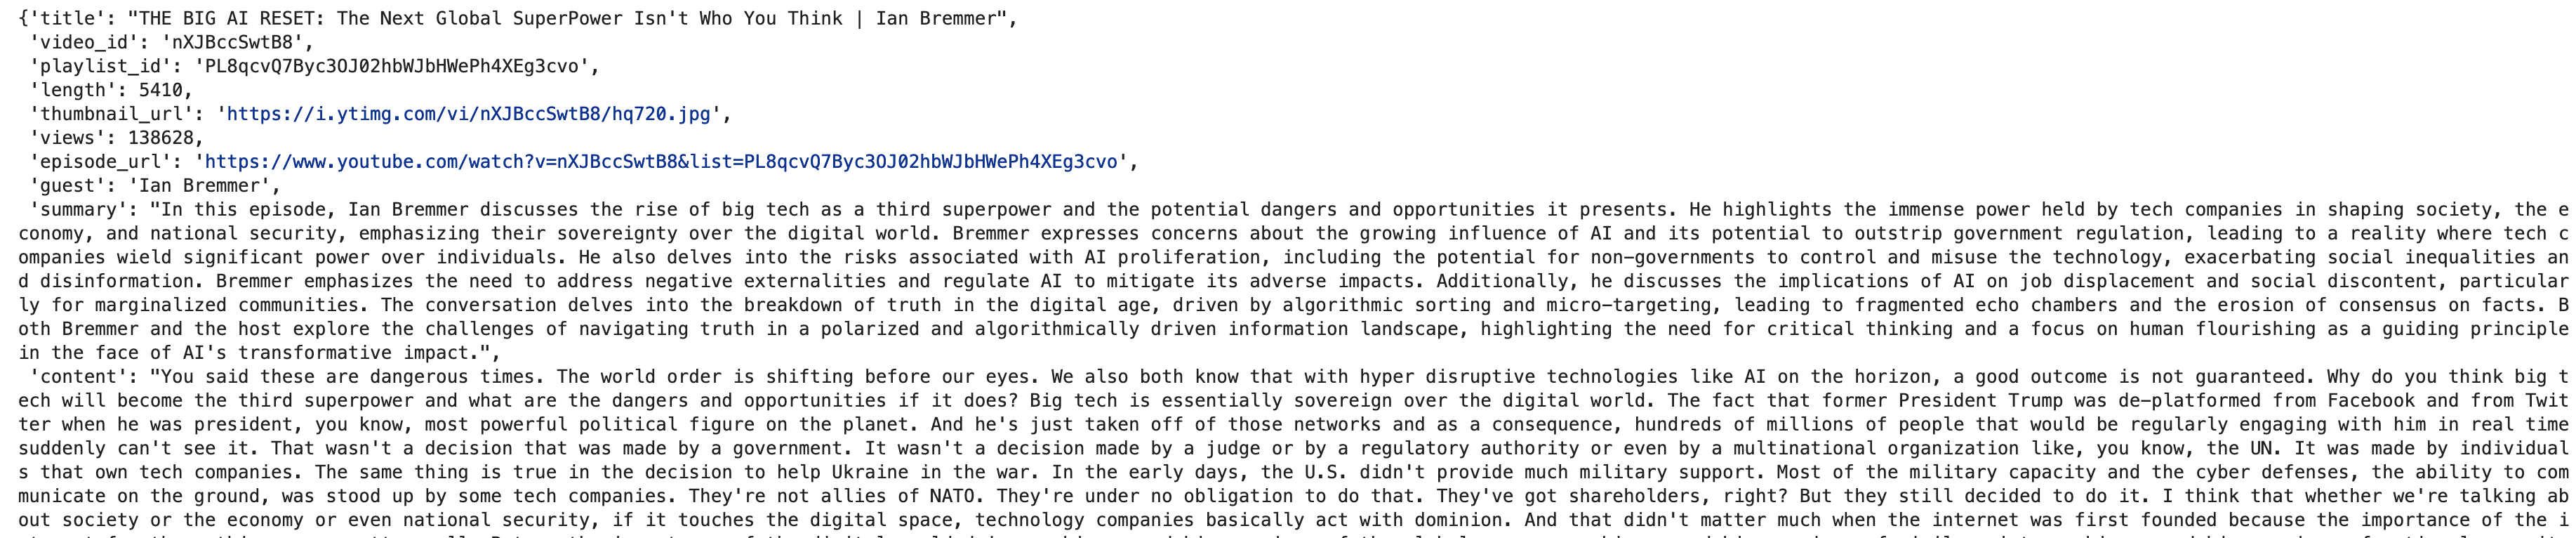)

By taking a peek at the data we can see that each entry contains episode metadata (title, views, episode length, etc.) as well as the transcript of the episode located in the `content` field.  In the example above the content has been truncated to fit on a single screen, but when you look at the data yourself, you'll see that the transcript is very long.  It may not jump out at you now, but we'll soon see that the `video_id` is one of the most important fields of the bunch, because it provides us with a unique identifier for each podcast episode.  Below is a down and dirty metadata glossary:

### Metadata Glossary
- **title**: Episode title.
- **video_id**: Unique identifier for each individual episode.
- **playlist_id**: Unique identifier for entire playlist of episodes.  All episodes in this dataset will have the same playlist_id.
- **length**: Length of the episode in total seconds.
- **thumbnail_url**: Hyperlink to the associated image of the YouTube episode.
- **views**: Number of views of this YouTube episode.
- **episode_url**: Hyperlink to the episode on YouTube.
- **guest**: Main guest for the episode.
- **summary**: Summary of the episode (AI generated).
- **content**: The full transcript of the episode.

As you'll see later in the course, each of these fields can be used to enhance a user's search experience.  For example we can use the `thumbnail_url` to provide the end user with a visualization, we can use the `title` as a means to boost our search by using keyword matching, and we can use the `guest` field (among others) to provide the end user with powerful filtering options.  The star of this show though, is the `content` field, as this is the field that we will be searching over when retrieving relevant documents.

Let's get some statistics on the length of the content for each episode. We'll count (roughly) the number of words in each episode by splitting on whitespace.

### Content Length Stats

In [8]:
contents = [d['content'] for d in data]
content_lengths = [len(content.split()) for content in contents]
df = pd.DataFrame(content_lengths, columns=['# Words'])
df.describe()

,# Words
count,384.000000
mean,12821.268229
std,7650.847177
min,1819.000000
25%,7888.000000
50%,9894.500000
75%,16857.000000
max,48502.000000


### Tokens
In the above example we split our content on whitespace which effectively splits the entire episode into a list of words....but LLMs [operate on tokens](https://uplimit.com/course/vector-search-apps/v2/enrollment/enrollment_clnnpb75t000j1aabfiqp1p9p/module/module_clo3hmx6f006a12doc6cf60ik). Tokens are words or sub-parts of words, so the word "texting" might be broken into two tokens `text` and `##ing`. Punctuation are also given their own tokens, so a period, a comma, or an apostropher are all going to have their own tokenized versions.  A [750 word document will be about 1000 tokens](https://www.anyscale.com/blog/num-every-llm-developer-should-know), in other words the token to word ratio is roughly 1.3 tokens = 1 word. Let's see what this looks like in practice.

In [9]:
mean_word_count = ceil(np.mean(content_lengths))
token_to_word_ratio = 1.3
approx_token_count = ceil(mean_word_count * token_to_word_ratio)
print(f'The mean word count for each episode is about {mean_word_count} words, which corresponds to a rough token count of {approx_token_count} tokens.')

The mean word count for each episode is about 12822 words, which corresponds to a rough token count of 16669 
tokens.

For the sake of precision, let's actually tokenize our content and see how close we get to the **1.3** `token_to_word_ratio`.  We'll use the tokenizer for the `gpt-3.5-turbo-0613` LLM (avilable through the `tikotken` library).  I'll discuss why I'm choosing this particular tokenizer later in the notebook.

In [10]:
import tiktoken # bad ass tokenizer library for use with OpenAI LLMs

#instantiate tokenizer for use with ChatGPT-3.5-Turbo
encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')

In [11]:
tokens = encoding.encode_batch(contents)
token_counts = list(map(len, tokens))
token_df = pd.DataFrame(token_counts, columns=['# Tokens'])
token_df.describe()

,# Tokens
count,384.000000
mean,15516.523438
std,9380.049480
min,2210.000000
25%,9523.750000
50%,12007.500000
75%,20268.000000
max,61559.000000


How close to this approximate **1.3 token:word** ratio were we....

In [12]:
true_ratio = round(np.mean(token_counts)/mean_word_count, 2)

#pretty close...
true_ratio

1.21

Let's get one more metric, let's see how big (in tokens) the size of our total corpus is:

In [13]:
total_tokens = sum(token_counts)
print(f'Total Tokens in Corpus: {total_tokens}')

Total Tokens in Corpus: 5958345

6 million tokens is no small matter, it's roughly equivalent to 10,000 pages of text, but to put things in perspective the Falcon-40B LLM was trained on a [1 trillion token](https://synthedia.substack.com/p/falcon-40b-llm-trained-on-1-trillion) corpus, which is 167,000 times larger than the one we are currently using! 🤯

<div class="alert alert-success"><h5>I encourage you to take a pause here and run any other text analytics that you like to familiarize yourself with the data.</h5></div>

### Embedding Tokens vs. LLM Tokens (i.e. Retriever vs. Reader)

We know that as part of our system we want to feed relevant context to an OpenAI LLM.  All LLMs, even the largest ones, have a limited input context window, so we'll have to take that into consideration as part of our system design.  But before we even get to that point, we have to first consider the maximum input sequence (in tokens) for our emebdding model.  Given that the mean token count for each of our podcast episodes is over 15K tokens, we'll need a way to chunk our content so that we can effectively embed the transcript into several meaningful embeddings as opposed to one embedding for the entire transcript. Let's address how we'll accomplish that task.

## Step 2 -->  Sentence Splitting and Chunking
***

### Chunking:
The open source embedding models that we will be working with have a `max_sequence_length` parameter far less than 15K tokens. In fact, the embedding model that we'll use: [`all-miniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), has a default max input length of 256 tokens. In order to effectively process the content of our podcast episodes, we'll need to decide on a **Chunking Strategy**. There are several ways to split a document into chunks, but the one we'll cover for this course involves the following steps, as outlined in the diagram below:

1. Gather documents.  In our case we're considering a single Impact Theory episode to be a "document".
2. Decide how to split your documents.  When working with text documents, a good starting strategy is to split on sentence boundaries.  This decision at the very least, prevents input text from randomly being cut off in the middle of a paragraph.  We'll use an excellent piece of code written by [LlamaIndex](https://github.com/run-llama/llama_index/blob/main/llama_index/node_parser/text/sentence.py) namely, the `SentenceSplitter` class.
3. Pick a chunk size based on your use case (refer to the detailed discussion in the [course notes](https://uplimit.com/course/vector-search-apps/v2/enrollment/enrollment_clnnpb75t000j1aabfiqp1p9p/module/module_clo3hmx6f006a12doc6cf60ik).  Given that the `all-miniLM-L6-v2` was trained on documents no greater than 256 tokens in length, we'll start with 256.  A chunk size of 256 strikes a good balance between information granularity and not blowing up the embedding space.
4. After splitting, a single episode will be broken up into `n` number of chunks, depending on the length of the episode.  Each of those chunks, however, should be no longer than 256 tokens.  Those chunks can then be passed through our embedding model as inputs and converted into vector representations.
5. The final step is combining the text chunks, their associated vectors, and the original metadata into a single dictionary (one for each chunk), in preparation for follow-on indexing on our Weaviate datastore.

![chunking strategy]( 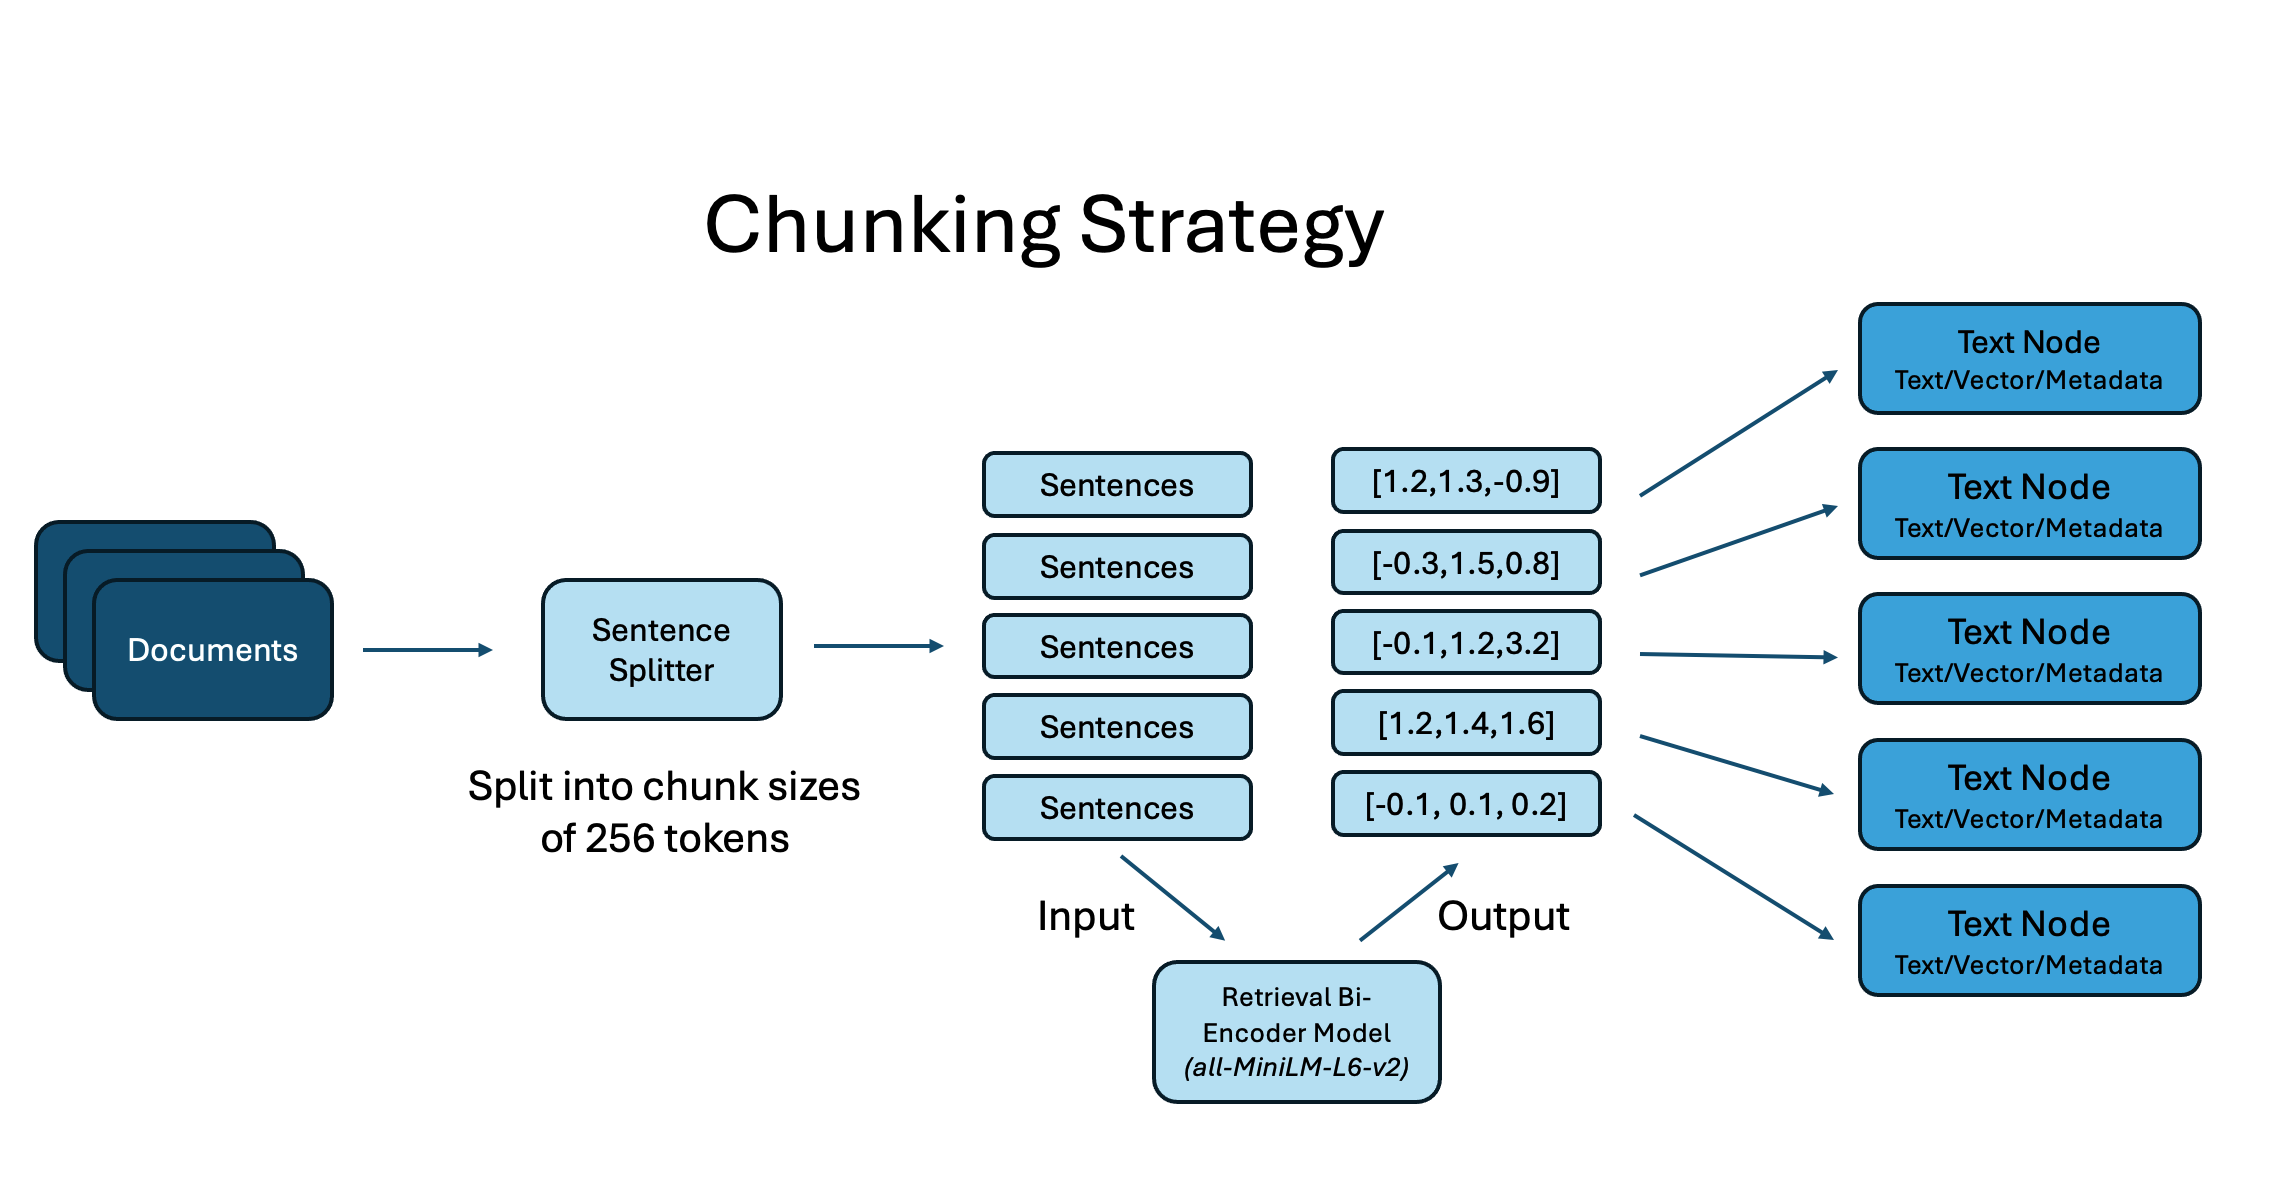)

#### Docstring for Llamaindex's SentenceSplitter Class

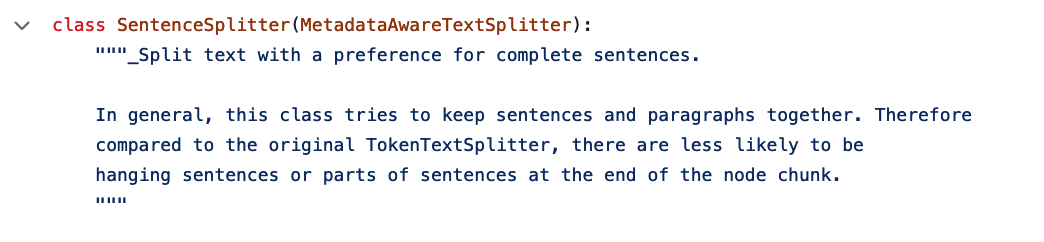

**A quick note here**: it's not necessary to pass in a tokenizer function into `SentenceSplitter`.  The default tokenizer under the hood is the GPT-2 tokenizer 🤷.  Technically, in the interest of precision it's probably a good practice to count tokens using the same tokenizer as the one your embedding model of choice was trained with.  But because the embeddding model we'll be using as our vector Retriever is going to be different from the model that will be performing Question Answering (the Reader), the tokenization counts will differ slightly.  In practice, this doesn't matter much in terms of Retriever performance, (at least for the use cases that I've worked with).  I bring it up now though as we are going to be chunking our data into `chunk_size` tokens.  Going forward we are going to use the `gpt-3.5-turbo-0613` tokenizer for creating chunk sizes.  I picked this one because:
1. It's fast. (no really, it is)
2. The token counts will be accurate (more or less) when we get to the Question Answering stage and have to aggregate responses into a single context for the OpenAI LLM.
3. There won't be a big retrieval performance difference using this tokenizer to count tokens compared with the original embedding model tokenizer.

The primary args that we'll review for the SentenceSplitter are:
- `chunk_size`: Too big and you lose information granularity because surrounding text mixes noise with signal.  Too small and you lose context to effectively address more complex questions, also if you go too small you'll start running into scaling challenges with your vector store.
- `tokenizer`: As discussed above we're going with the gpt-3.5-turbo tokenizer for speed and standarization. The `SentenceSplitter` class is a little odd in that this param takes a `tokenizer.encode` function as opposed to the actual tokenizer itself.
- `chunk_overlap`: Practioners oftentimes will give a 20-40 token overlap value to capture additional context.  This also has the effect of introducing vectors that contain duplicate information, which is an annoying problem to have.  We're going to set this param to 0 and address adding context in other ways.

<div class="alert alert-danger"><h5>Retrieval benchmarks that we'll be running will depend on using the `gpt-3.5-turbo-0613` encoding, a 256 chunk_size, and 0 overlap, so be sure to use them when chunking text throughout this notebook.</h5></div>
  
  **YOU'VE BEEN WARNED!** 😈

In [14]:
from llama_index.text_splitter import SentenceSplitter #one of the best on the market

#set chunk size and instantiate your SentenceSplitter
chunk_size = 256
gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=0)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Assignment 1.1 - Chunking the Data

#### *Write a function that will split the original podcast episodes into chunks of chunk_size = n.  Output will be a list of 384 lists of various sizes (due to varying episode lengths).*

#### Why: We need to split our podcast episode transcripts into chunks of text in preparation for converting into embeddings.
<details>
  <summary>Click to reveal helper instructions</summary>
  
#### INSTRUCTIONS
1. Iterate over the `corpus` of podcast episodes (use `tqdm` to visualize progress)
2. Extract the content (transcript) from each episode (use the `content_field` arg for this)
3. Split the `content` field using the `text_splitter.split_text` method
4. Return a list of lists of chunked texts (count should still be 384)
</details>
<br>

**#HINT:** This function can be written in a single line of code

In [15]:
def split_contents(corpus: List[dict],
                   text_splitter: SentenceSplitter,
                   content_field: str='content'
                   ) -> List[List[str]]:
    '''
    Given a corpus of "documents" with text content, this function splits the
    content field into chunks sizes as specified by the text_splitter.

    Example
    -------
    corpus = [
            {'title': 'This is a cool show', 'content': 'There is so much good content on this show. \
              This would normally be a really long block of content. ... But for this example it will not be.'},
            {'title': 'Another Great Show', 'content': 'The content here is really good as well.  If you are \
              reading this you have too much time on your hands. ... More content, blah, blah.'}
           ]

    output = split_contents(data, text_splitter, content_field="content")

    output >>> [['There is so much good content on this show.', 'This would normally be a really long block of content.', \
                 'But for this example it will not be'],
                ['The content here is really good as well.', 'If you are reading this you have too much time on your hands.', \
                 'More content, blah, blah.']
                ]
    '''

    return [text_splitter.split_text(doc[content_field]) for doc in tqdm(corpus)]


In [16]:
corpus = [
        {'title': 'This is a cool show', 'content': 'There is so much good content on this show. \
          This would normally be a really long block of content. ... But for this example it will not be.'},
        {'title': 'Another Great Show', 'content': 'The content here is really good as well.  If you are \
          reading this you have too much time on your hands. ... More content, blah, blah.'}
        ]

content_splits = split_contents(corpus, gpt35_txt_splitter)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
content_splits

[['There is so much good content on this show.           This would normally be a really long block of content. ... But for this example it will not be.'],
 ['The content here is really good as well.  If you are           reading this you have too much time on your hands. ... More content, blah, blah.']]

### Unit Test to ensure you're on the right track

In [18]:
import unittest
from unitesting_utils import load_impact_theory_data

class TestSplitContents(unittest.TestCase):
    '''
    Unit test to ensure proper functionality of split_contents function
    '''

    def test_split_contents(self):
        import tiktoken
        from llama_index.text_splitter import SentenceSplitter

        data = load_impact_theory_data()

        subset = data[:3]
        chunk_size = 256
        chunk_overlap = 0
        encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')
        gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=chunk_overlap)
        results = split_contents(subset, gpt35_txt_splitter)
        self.assertEqual(len(results), 3)
        self.assertEqual(len(results[0]), 83)
        self.assertEqual(len(results[1]), 178)
        self.assertEqual(len(results[2]), 144)
        self.assertTrue(isinstance(results, list))
        self.assertTrue(isinstance(results[0], list))
        self.assertTrue(isinstance(results[0][0], str))
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestSplitContents))

  0%|          | 0/3 [00:00<?, ?it/s]

.
----------------------------------------------------------------------
Ran 1 test in 0.544s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Analysis of Episode Length

Take the time to explore your splits and see what they look like.  It's useful to get a sense of the data you'll be working with, below I've provided a quick and simple analysis of how many tokens are used for each podcast episode.

In [19]:
#helper function to capture the lengths of each split

def get_split_lengths(splits: List[List[str]], column_name: str='Split Lengths') -> pd.DataFrame:
    '''
    Given a list of text splits, returns the length of each split
    in a pandas DataFrame.
    '''
    lengths = list(map(len, splits))
    return pd.DataFrame(lengths, columns=[column_name])

**Replace `None` below with the output from the split_contents function**

  0%|          | 0/384 [00:00<?, ?it/s]

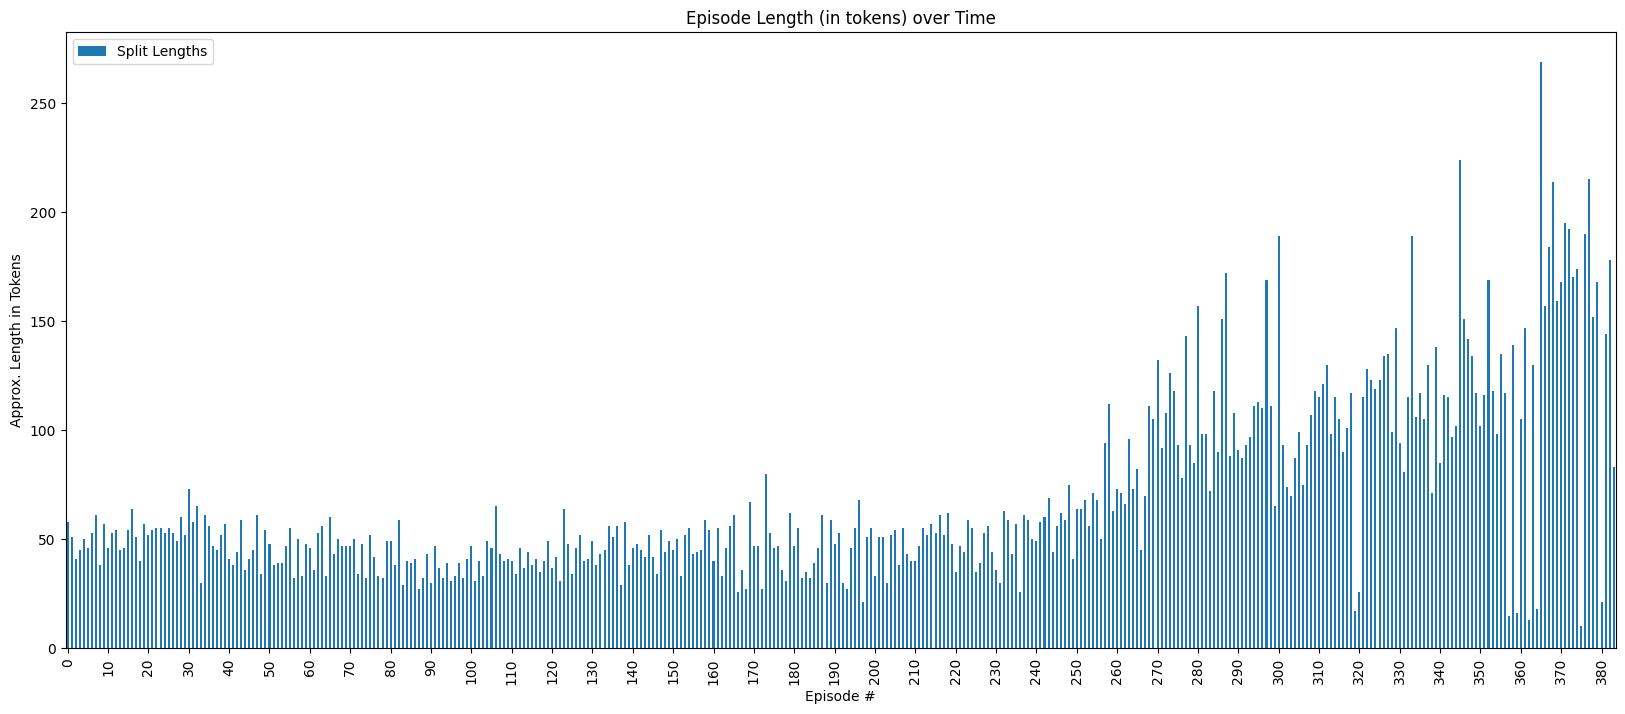

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

column_name = 'Split Lengths'

splits = split_contents(data, gpt35_txt_splitter)

# replace None with the output from the split_contents function
df = get_split_lengths(splits, column_name=column_name)


# reverse the order of the episode # to correctly show left to right chronological order
df.index = sorted(list(df.index), reverse=True)
# create plot
ax = df.iloc[::-1].plot.bar(y='Split Lengths', xlabel='Episode #', ylabel='Approx. Length in Tokens', title='Episode Length (in tokens) over Time', figsize=(20,8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

<details>
  <summary>Draw your own conclusions and then Click here</summary>  
There is a clear trend of episodes increasing in length over time.  One can also see that there is an occasional episode (in the later block of shows) that is significantly shorter in length than other episodes of the same time period.  My thought here is that those are truncated episodes, meaning the author, for whatever reason, did not publish the episode in its entirety. The conclusions we can draw from this simple analysis will not affect the way we build our IR system, however, it's always a good idea to become as familiar with your data/domain as much as possible.
</details>

## Step 3 -->  Encode Text Chunks as Vectors

#### SentenceTransformers

In 2019, about a year after the original BERT model was released, Nils Reimers and Iryna Gurevych dropped a bomb on the NLP community by open sourcing their research on sentence-level embeddings: [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf).  Their accompanying [sentence-transformers](https://www.sbert.net/) library provided NLP practioners with access to state of the art sentence-level embeddings, and remains a powerful option even today.

#### Model Selection
Model selection is kind of a big deal...For starters we are going to use the `all-MiniLM-L6-v2` variant because it's actually quite good out of the box and it also happens to be very fast (at embedding creation).  [Click here](https://www.sbert.net/docs/pretrained_models.html) for a comprehensive list of available pretrained SentenceTransformers (these are all available through the HuggingFace API):

![Pretrained Model List]( 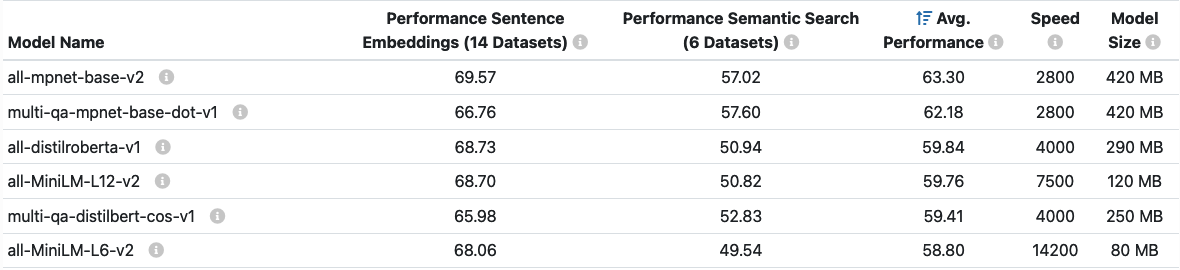)

This model card provides great information at a glance and allows practitioners to do a comprehensive comparison of available models.  If you're on the [website](https://www.sbert.net/docs/pretrained_models.html) and you click on the shaded grey info circle, it will show additional details about each model.  Becuase we are building an Information Retrieval system that utilizes Vector Search, we're going to be most interested in the following numbers:
- Performance Semantic Search
- Speed (encoding speed)
- Model Size

Right off the bat you can see that the `all-MiniLM-L6-v2` is the worst performing of the group, so why use it?  If you look at the **Speed** column you'll note that this model is almost 7x times faster than the two highest performing models.  The numbers in the Speed column represent number of sentences encoded per second, ("sentences" here referring to any chunk of text longer than a single word but less than the `max_sequence_length` of the model). For comparison I ran a quick experiment pitting the `all-MiniLM` against the `all-mpnet-base-v2`.  After chunking the Impact Theory episodes it took the `all-MiniLM` 33 seconds to encode all 384 episodes, whereas the `all-mpnet` took over 5 minutes.  That's almost 10x longer! However, given that the intial text embedding process occurs as an offline process, the increase in performance from the `all-mpnet` may be worth the extra time, it really all depends on whether your system will be constantly updating it's corpus, the size of your data, and the observed performance gains.  Given the small amount of data we are using for this course, those numbers don't matter very much, but it's a point to consider if you are working with a much larger corpus.

Ultimately model selection comes down to your use case and the trade-off between performance and latency (and to a degree the size of the model on disk).  Starting in Notebook 3 of the course, you'll have the chance to experiment with different embedding models to see how they can boost retrieval performance in your system.  When you're ready for that step head on over to the [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) where you can check out the latest state of the art embedding models.  The `all-MiniLM-L6-v2` ranks a lowly 47th on the Retrieval task.  

Let's take the `all-MiniLM` out for a spin before the next assignment....

In [21]:
from sentence_transformers import SentenceTransformer

#define the model you want to use
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
model

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

A quick glance at the model configuration shows us the following information:
- **Max sequence length:** (or input length) is 256 tokens.  The underlying model is a BERT model, so technically we could adjust this parameter to 512 tokens, however, because the model was trained on inputs of no greater than 256 tokens, we'll keep the default.
- **The embedding dimension:** (i.e. the output vector) is 384 dimensions.  Make sure not to confuse the `max_sequence_length` with the embedding dimesion.  The maximum sequence length is the maximum number of input tokens the model will process before truncating any text over that limit, and the emnbedding dim is the length of the output vector which always remains fixed in size.
- **Pooling Layer:** this model uses the mean token pooling strategy for creating a fixed sized embedding from all vector outputs.

#### Model Encoding

![sbert_docstring]( 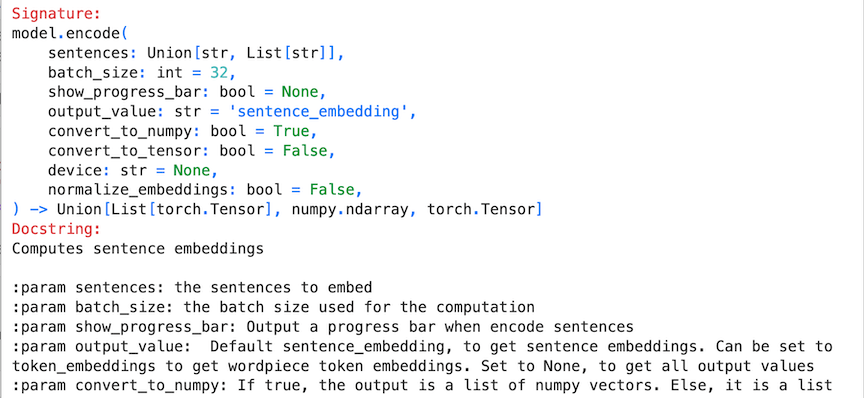)

We are going to work solely with the `model.encode` method for our text embedding creation.  There is a surprising amount of work being done under the hood with this function to include word tokenization, batching, GPU device setting, etc. If you really must know, feel free to review [lines 111 - 202 in the sentence-transformers Github repo](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/SentenceTransformer.py).  Here's a few notes for our course:
- `sentences`: accepts either a single string or a list of strings.  Very convenient.  This will allow us to enter all of the chunks from a single podcast episode at once, allowing for efficient processing and episode integrity.
- `batch_size`: under the hood the list of sentences in the input is batched.  Default is 32, so if your input was 128 sentences, then the model would translate that into 4 batches for processing.  DataLoader not needed.  Assuming you are using Google Colab for this notebook, use the default setting.
- `convert_to_numpy`: default output is a numpy array. However, because Weaviate does not accept the np.array data type, we'll want to eventually convert these arrays into Python lists.
- `device`: set to either cpu or GPU (`"cuda:0"`) for single GPU.  If `None` the function will handle this step for you and choose the fastest option!

Let's take a quick tour of how this function works in practice.

In [22]:
#create sample sentences
text1 = "I ran down the road"
text2 = "I ran down the street"
text3 = "I ran down the lane"
text4 = "I ran down the avenue"
text5 = "I ran over to the house"

In [23]:
road_sentences = [text1, text2, text3, text4, text5]
road_vectors = model.encode(road_sentences)

In [24]:
road_vectors, road_vectors.shape

(array([[ 0.01464681,  0.05611011,  0.02563805, ..., -0.09253474,
         -0.04195406, -0.04409866],
        [ 0.04675806,  0.07742156,  0.04562968, ..., -0.08124164,
         -0.10972544, -0.0254627 ],
        [ 0.06553329,  0.09942432, -0.04012908, ...,  0.00221835,
         -0.03429253, -0.04802391],
        [ 0.05736331,  0.08300824,  0.00926694, ..., -0.10420121,
         -0.10806054, -0.03672468],
        [ 0.06660572,  0.03724339,  0.02164608, ..., -0.01440302,
         -0.11986511,  0.00423096]], dtype=float32),
 (5, 384))

As mentioned earlier the output vector dimension is 384 for this model, so we should expect to see 5 vectors of length 384 dims.  
Given that all of these vectors are of the same length we can compare them in vector space using a cosine simlarity function.  
The sentence-transformer's `semantic_search` function allows us to compare a single text (or multiple) to multiple texts and ranks them based on distance in vector space.  

In [25]:
from sentence_transformers.util import semantic_search

# we need to reencode our texts here with pytorch tensors to work with the semantic_search function
tensors = model.encode(road_sentences, convert_to_tensor=True)

# we'll set our query to the first sentence
query = model.encode(text1, convert_to_tensor=True)

#compare our query with all of the other sentences, including itself (expect to see a cossim value of 1)
results = semantic_search(query_embeddings=query, corpus_embeddings=tensors)[0]
for result in results:
    print(f'Score: {round(result["score"],3)} - {road_sentences[result["corpus_id"]]}')

Score: 1.0 - I ran down the road

Score: 0.905 - I ran down the street

Score: 0.823 - I ran down the lane

Score: 0.805 - I ran down the avenue

Score: 0.673 - I ran over to the house

Here we can see that the word `road` is most semantically similar to itself, followed by the word `street`, followed by `lane`, and finally followed by `avenue`.  The final entry "`I ran over to the house`" is much further away in vector space, relatively, than the other sentences. As discussed in the course notes, embeddings measures the similarity between strings.  The next example shows how this concept of "similarity" is not always as intuitive as one might think.

In [26]:
#define some semantically similar sentences
passages = ['Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams',
            'Tom Bilyeu founded Quest Nutrition in 2010',
            'Tom Bilyeu, not known outside of those who listen to the Impact THeory',
            'Tom Bilyeu claims to have deadlifted 335 pounds on his show',
            'Tomcats are not neutered cats']

#we'll define a query that should be able to be answered by the passages
query = "Who is Tom Bilyeu"

tom_tensors = model.encode(passages, convert_to_tensor=True)
tom_query = model.encode(query, convert_to_tensor=True)
tom_results = semantic_search(query_embeddings=tom_query, corpus_embeddings=tom_tensors)
for result in tom_results[0]:
    print(f'Score: {round(result["score"],3)} - {passages[result["corpus_id"]]}')

Score: 0.709 - Tom Bilyeu, not known outside of those who listen to the Impact THeory

Score: 0.671 - Tom Bilyeu is the host of Impact Theory and has helped millions achieve their dreams

Score: 0.67 - Tom Bilyeu founded Quest Nutrition in 2010

Score: 0.639 - Tom Bilyeu claims to have deadlifted 335 pounds on his show

Score: 0.248 - Tomcats are not neutered cats

Take a look at the results, are you surprised by their rankings?  It's clear that the lowest scoring result deserves to be at the bottom, but I think one could argue that the second and third result could exchange places or be ranked first given the query passage. We'll learn later on in Notebook 4 that [CrossEncoders](https://www.sbert.net/examples/applications/cross-encoder/README.html) can be helpful in re-ranking our returned results more accurately than their bi-encoder counterparts, and we'll learn a couple of other techniques that will help with turning up our information gain.

# Assignment 1.2 - Create Episode Embeddings:

#### *Write a function that will vectorize each content split list (single episode) and then merge the text content and their vector representations into a single list of (text, vector) tuples.  Gather all episode lists into a single large list.*

#### Why: We need to preserve the ordering of the text and their vector representations

<details>
  <summary>Click to reveal helper instructions</summary>  
    
#### INSTRUCTIONS
1. Iterate over the `content_splits`
2. For each list of content splits, call the model's `encode` method on the entire split/batch.  
3. Merge the text splits and resultant vectors into a single list of (text, vector) tuples.  
4. Append each list of tuples to the `text_vector_tuples` list container and return when complete.
</details>

- **#HINT**: use `tqdm` to track your progress when iterating over `content_splits`
- **#HINT**: when merging your text splits and associated vectors, `zip` is your friend here
- **#HINT**: benchmarked on Google Colab with a standard T4 GPU this step takes about 90 seconds to process (with the `all-MiniLM-L6-v2` model).

In [27]:
def encode_content_splits(content_splits: List[List[str]],
                          model: SentenceTransformer,
                          device: str='cuda:0'
                          ) -> List[List[Tuple[str, np.array]]]:
    '''
    Encode content splits as vector embeddings from a list of content splits
    where each list of splits is a single podcast episode.

    Example
    -------
    content_splits =  [['There is so much good content on this show.', 'This would normally be a really long block of content.'],
                       ['The content here is really good as well.', 'More content, blah, blah.']
                      ]

    output = encode_content_splits(content_splits, model)

    output >>> [
          EPISODE 1 -> [('There is so much good content on this show.', array[ 1.78036056e-02, -1.93265956e-02,  3.61164124e-03, -5.89650944e-02,
                                                                         1.91510320e-02,  1.60808843e-02,  1.13610983e-01,  3.59948091e-02,
                                                                        -1.73066761e-02, -3.30348089e-02, -1.00898169e-01,  2.34847311e-02]
                                                                        )
                         tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
          EPISODE 2 ->  [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
          EPISODE 3 ->  [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....],
          EPISODE n ... [tuple(text, np.array), tuple(text, np.array), tuple(text, vector)....]
    '''

    return [[(chunk, model.encode(chunk)) for chunk in content_split] for content_split in tqdm(content_splits)]

In [28]:
text_vector_tuples = encode_content_splits(splits, model)

  0%|          | 0/384 [00:00<?, ?it/s]

### Unit Test to ensure you're on the right track

In [29]:
import unittest
from unitesting_utils import load_impact_theory_data

class TestEncodeContentSplits(unittest.TestCase):
    '''
    Unit test to ensure proper functionality of split_contents function
    '''

    def test_encode_content_splits(self):
        import tiktoken
        from numpy import ndarray
        from llama_index.text_splitter import SentenceSplitter
        from sentence_transformers import SentenceTransformer

        data = load_impact_theory_data()

        #get splits first
        subset = data[:3]
        chunk_size = 256
        chunk_overlap = 0
        encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')
        gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=chunk_overlap)
        splits = split_contents(subset, gpt35_txt_splitter)

        #encode splits
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        results = encode_content_splits(splits, model)

        #run assertion tests
        self.assertEqual(len(results), 3)
        self.assertEqual(len(results[0]), 83)
        self.assertEqual(len(results[1]), 178)
        self.assertEqual(len(results[2]), 144)
        self.assertTrue(isinstance(results, list))
        self.assertTrue(isinstance(results[0], list))
        self.assertTrue(isinstance(results[0][0], tuple))
        self.assertTrue(isinstance(results[0][0][0], str))
        self.assertTrue(isinstance(results[0][0][1], ndarray))
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEncodeContentSplits))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

.
----------------------------------------------------------------------
Ran 1 test in 4.616s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Assignment 1.3 - Combining Metadata with Text/Vectors

#### *Write a function that will combine episode metadata from the original corpus with their associated text/vector tuples*
#### Why: We don't want our metadata to go to waste.  Now that we have our text/vector tuples grouped by episode, we can easily join all of that information together with each episode's metadata.
    
#### INSTRUCTIONS
1. `enumerate` over the `corpus`.  We'll use the count (`i`) from this iteration to associate each inner list in step two with each episode from the `corpus` list.
2. `enumerate` over each inner list of `text_vector_list` at index `i`.  We'll use the count (`j`) from this iteration as a suffix when creating a new `doc_id` field (see step 4). Reminder, in this step we are iterating over a list of lists, where each inner list is a single podcast episode of text/vector tuples.
3. Create a new dictionary filled with all items from `corpus[i]` except for the `content` field.  **#HINT**: use a dict comprehension here.
4. Update the new dict with a `doc_id` field by extracting the `video_id` value and combining it with the count (`j`) as a single string.
   **#HINT**: `doc_id = f'{video_id}_{j}'`
5. Update the new dict with a `content` field using the text from the enumerated tuple
6. Update the new dict with a `content_embedding` field using the vector from the enumerated tuple. Coerce the vector `type` from a `np.array` to a `list`.
7. Append each new dict to the `joined_documents` list container and return when complete.

**#HINT**: Assuming average CPU performance, this function should execute under 2 seconds with 384 episodes.

#### Example of Sample output entry (what a single doc should look like)

![doc_example]( 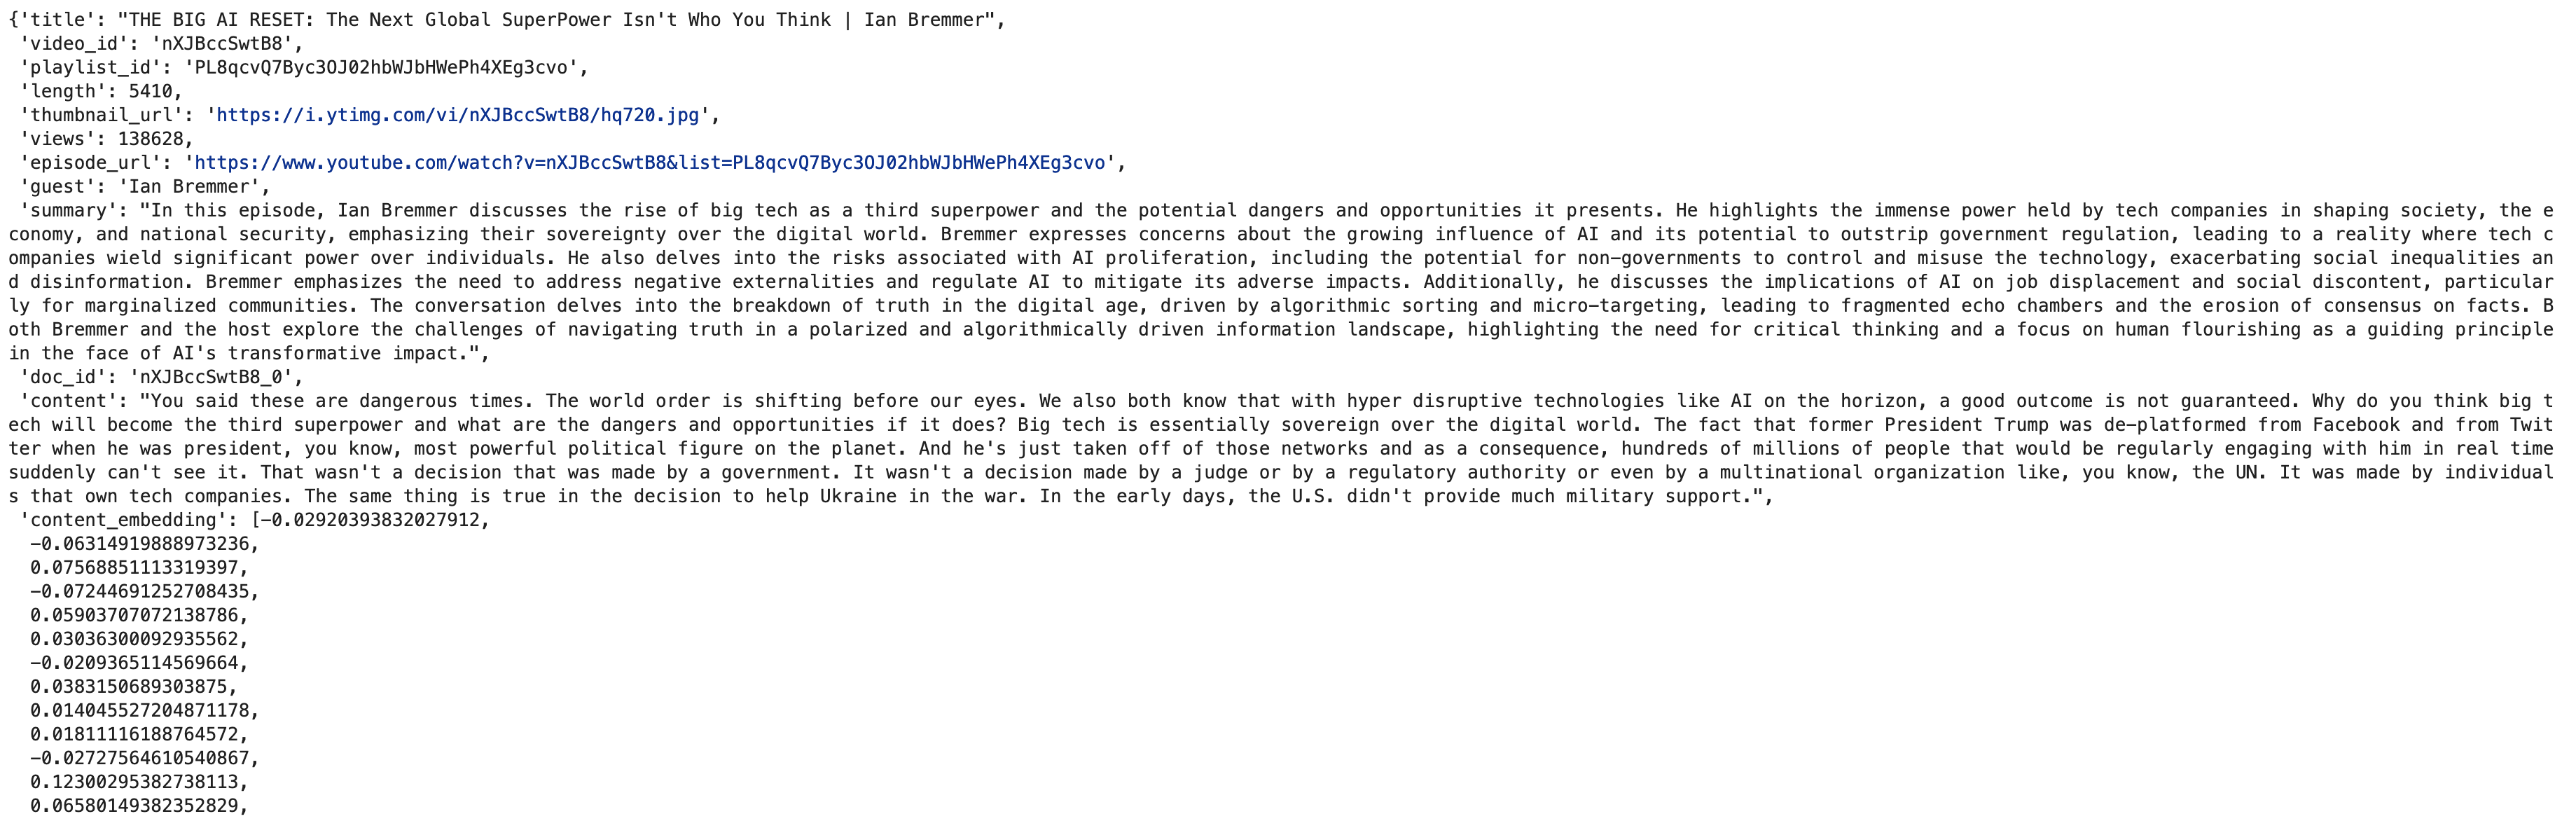)
*** `content_embedding` field has been truncated

In [40]:
def join_metadata(corpus: List[dict],
                  text_vector_list: List[List[Tuple[str, np.array]]],
                  content_field: str='content',
                  embedding_field: str='content_embedding'
                 ) -> List[dict]:
    '''
    Combine episode metadata from original corpus with text/vectors tuples.
    Creates a new dictionary for each text/vector combination.
    '''

    joined_documents = []
    for i, episode_metadata in enumerate(corpus):
      for j, vector in enumerate(text_vector_list[i]):
        doc = {k:v for k,v in episode_metadata.items() if k != content_field}
        doc['doc_id'] = f'{episode_metadata["video_id"]}_{j}'
        doc[content_field] = vector[0]
        doc[embedding_field] = list(vector[1])
        joined_documents.append(doc)

    ########################
    # START YOUR CODE HERE #
    ########################

    return joined_documents

In [43]:
#create your dataset when ready
docs = join_metadata(data, text_vector_tuples)

### Unit Test to ensure you're on the right track

In [44]:
import unittest
from unitesting_utils import load_impact_theory_data

class TestEncodeContentSplits(unittest.TestCase):
    '''
    Unit test to ensure proper functionality of split_contents function
    '''

    def test_encode_content_splits(self):
        import tiktoken
        from numpy import ndarray
        from llama_index.text_splitter import SentenceSplitter
        from sentence_transformers import SentenceTransformer

        data = load_impact_theory_data()

        #get splits first
        subset = data[:3]
        chunk_size = 256
        chunk_overlap = 0
        encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')
        gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=chunk_overlap)
        splits = split_contents(subset, gpt35_txt_splitter)

        #encode splits
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        text_vector_tuples = encode_content_splits(splits, model)

        #joint metadata
        results = join_metadata(subset, text_vector_tuples)

        print(results[0]['doc_id'])

        #run assertion tests
        self.assertEqual(len(results), 405)
        self.assertEqual(len(results[0]), 12)
        self.assertTrue(isinstance(results, list))
        self.assertTrue(isinstance(results[0], dict))
        self.assertTrue(isinstance(results[0]['content'], str))
        self.assertEqual(results[0]['doc_id'], 'nXJBccSwtB8_0')
        self.assertEqual(len(results[0]['content_embedding']), 384)
        self.assertTrue(isinstance(results[0]['content_embedding'], list))
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEncodeContentSplits))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

nXJBccSwtB8_0

.
----------------------------------------------------------------------
Ran 1 test in 4.668s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

## Step 4 --> Save (and Download) Your Hard Work!

We've reached the final step in our data preparation phase.  If you've made it this far, you should have 26,448 distinct documents and are now ready to index those documents on your **Weaviate host/database**. Before moving on to the indexing step, we'll want to store our dataset on disk.

The FileIO Class is a convenient wrapper that makes it easy to save data to disk in either json or [parquet format](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705).  The choice is yours on which format to use, however, a note of caution: the json format will take up 3-4x more room on disk than parquet. In the example screenshot below, you can see that the json clocks in at 390Mb while the parquet is only 77Mb. If you are using Github Codespaces as your environment for this course, then I definitely recommend using the parquet format, because there are storage limits in Codespaces and you may be creating several datasets over the course of 2 weeks.

![json_example]( 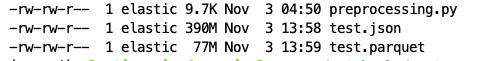)

Final note before saving: it's always a good idea to decide on a naming convention when saving out datasets, especially when the plan is to create multiple versions.  With that said, I suggest the following guidelines:
1. Name the dataset so it's easy to identify i.e. the name of the show: `impact-theory`
2. Hyphenate the name with the model used for text embeddings: `minilmL6`
3. Hyphenate the `chunk_size` you used for text chunking: `256`
4. If you really want to get specific you can also add a datetime suffix to the end, but that's up to you.

#### Example Naming Convention
`impact-theory-minilmL6-256.parquet`

In [46]:
#instantiate FileIO Class
io = FileIO()

#Define your output path
outpath = "./data/impact-theory-minilmL6-256.parquet"

#save to disk
io.save_as_parquet(file_path=outpath, data=docs, overwrite=False)

2023-12-11 17:18:36.920 | INFO     | preprocessing:save_as_parquet:41 - DataFrame saved as parquet file here: ./data/impact-theory-minilmL6-256.parquet


In [47]:
#Verify that you can reload data

data_with_vectors = io.load_parquet(file_path=outpath)
data_with_vectors[0]

Shape of data: (26448, 12)
Memory Usage: 2.42+ MB


{'title': "THE BIG AI RESET: The Next Global SuperPower Isn't Who You Think | Ian Bremmer",
 'video_id': 'nXJBccSwtB8',
 'playlist_id': 'PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
 'length': 5410,
 'thumbnail_url': 'https://i.ytimg.com/vi/nXJBccSwtB8/hq720.jpg',
 'views': 138628,
 'episode_url': 'https://www.youtube.com/watch?v=nXJBccSwtB8&list=PL8qcvQ7Byc3OJ02hbWJbHWePh4XEg3cvo',
 'guest': 'Ian Bremmer',
 'summary': "In this episode, Ian Bremmer discusses the rise of big tech as a third superpower and the potential dangers and opportunities it presents. He highlights the immense power held by tech companies in shaping society, the economy, and national security, emphasizing their sovereignty over the digital world. Bremmer expresses concerns about the growing influence of AI and its potential to outstrip government regulation, leading to a reality where tech companies wield significant power over individuals. He also delves into the risks associated with AI proliferation, including the pote

#### Download your data  
This notebook assumes students are running this notebook from a Google Colab environment.  If you aren't, then this last section won't apply to you.   
**Download data steps**
- On the left hand side of the Colab notebook you'll see a folder icon.  Click it to reveal the current working directory.
- Locate the dataset that you just saved (assuming you saved it in the current working directory), and click on the three dots which will reveal a drop down menu.
- Click on the "Download" option.

![Colab]( 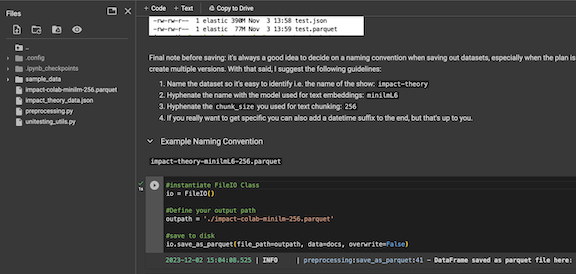)  

![download]( 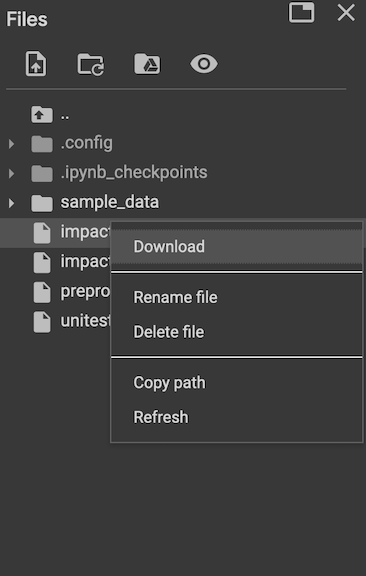)

# **OPTIONAL- Create Dataset (shell code)

#### *Write a function that will create a dataset given a raw corpus, an embedding model, and a text splitter.*
#### INSTRUCTIONS

1. Fill in the rest of the code wherever you see **None**, using the functions you wrote in the previous assignments.
   **Caveat: The type hint for the returned output is `None`, so no need to change it.**

In [48]:
def create_dataset(corpus: List[dict],
                   embedding_model: SentenceTransformer,
                   text_splitter: SentenceSplitter,
                   file_outpath_prefix: str='./impact-theory-minilmL6',
                   content_field: str='content',
                   embedding_field: str='content_embedding',
                   device: str='cuda:0' if cuda.is_available() else 'cpu'
                   ) -> None:
    '''
    Given a raw corpus of data, this function creates a new dataset where each dataset
    doc contains episode metadata and it's associated text chunk and vector representation.
    Output is directly saved to disk.
    '''

    io = FileIO()

    chunk_size = text_splitter.chunk_size
    print(f'Creating dataset using chunk_size: {chunk_size}')
    start = time.perf_counter()
    ########################
    # START YOUR CODE HERE #
    ########################
    content_splits = None
    text_vector_tuples = None
    joined_docs = None
    ########################
    # END YOUR CODE HERE #
    ########################
    file_path = f'{file_outpath_prefix}-{chunk_size}.parquet'
    io.save_as_parquet(file_path=file_path, data=joined_docs, overwrite=False)
    end = time.perf_counter() - start
    print(f'Total Time to process dataset of chunk_size ({chunk_size}): {round(end/60, 2)} minutes')

# Conclusion
***

And that....is a wrap.  I realize this was a big notebook, with a lot of information thrown your way, my hope is that as you are applying the methods in this notebook you are considering how you would use these same principles within your own work/personal context.  As always, if you come across roadblocks, be sure to ask any questions you have in the course Slack channel.  
<div class="alert alert-success"><h5>And don't lose those datasets!  We'll need them for the next phase in our journey: Indexing and Search!</h5></div>

<br>  

# **OPTIONAL: OpenAI Ada Embeddings
***
## **WARNING: HIGHLY RECOMMEND THAT YOU RUN THIS EXERCISE LOCALLY.  
## THE EMBEDDINGS GENERATED TAKE UP 250MB OF DISK SPACE AND WILL TAKE OVER 30 MINUTES TO DOWNLOAD FROM GOOGLE COLAB

This optional section explores the process for creating text embeddings using the powerful OpenAI model `text-embedding-ada-002`.  For additional details about this process see the OpenAI [Embeddings documentation](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings).

### Overview

Even if you don't plan on using the `text-embedding-ada-002` model for your particular use case, this exercise will, at the very least, provide you with a basis for comparison against one of the most popular (currently) embeddings frameworks on the commercial market.  While there are several ways to approach embeddings creation through the OpenAI API, we will use the code provided by LlamaIndex, as it is one the cleanest implementations that I've seen.  The output from this exercise will be a pandas DataFrame of text/vector pairs similar to what we derived from Assignment 1.2.

In [49]:
!pip install openai==1.3.5 --quiet
#if not already installed from earlier in the notebook
#!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [50]:
import openai
import tiktoken
from tiktoken import Encoding
from typing import Union, List, Tuple
from getpass import getpass

In [54]:
#set api key
openai.api_key = getpass()

··········


### Instantiate tokenizer/encoder

In [55]:
#define the model we want to use for the tokenizer
model_type = "text-embedding-ada-002"
encoding = tiktoken.encoding_for_model(model_type)

### Load data
**Only necessary if the data wasn't already loaded earlier in the notebook**

In [ ]:
# data_path=''
# with open(data_path) as f:
#     data = json.load(f)

### Extract contents

In [56]:
#only need the contents from our data
contents = [d['content'] for d in data]

### Split contents

In [57]:
# from llama_index.text_splitter import SentenceSplitter #one of the best on the market

# #set chunk size and instantiate your SentenceSplitter
chunk_size = 256
gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=0)
splits = [gpt35_txt_splitter.split_text(episode) for episode in tqdm(contents)]

  0%|          | 0/384 [00:00<?, ?it/s]

### Estimate cost of job

As a best practice, it's always a good idea to estimate the cost of using OpenAI **prior** to kicking off a job.  The `get_cost` function does just that.  It takes an encoder, which we defined previously, and a corpus, and allows the user to set the price per 1,000 tokens.  The price will change depending on what action you're looking to take, but the default is $0.0001 per 1,000 tokens which is the current (Nov 2023) cost for using the `text-embedding-ada-002` endpoint.

In [58]:
#should match previously calculated token count for corpus
def get_cost(encoder: Encoding,
             corpus: Union[str, List[str]],
             price: float=0.0001,
             return_tokens: bool=False
             ) -> Union[float, Tuple[float, List[int]]]:
    '''
    Given a text encoder and a corpus of text, this function will calculate the total
    cost, as determined by the price param, of using the OpenAI API. The price is
    per 1,000 tokens.
    '''
    if isinstance(corpus, str):
        encoded = encoder.encode(corpus)
        token_count = len(encoded)
    elif isinstance(corpus, list):
        encoded = encoder.encode_batch(corpus)
        token_count = sum(list(map(len, encoded)))
    print(f'Total Tokens: {token_count}')
    cost = token_count//1000 * price
    print(f'Total Cost: ${cost:.2f}')
    if return_tokens:
        return cost, encoded
    return cost

The Total Tokens should match the same number we derived when capturing analytics on our corpus earlier in the notebook.  At a price of \\$0.0001 per 1,000 tokens, we can see that this text embeddings action should cost about \\$0.60 (60 cents). In preparation for this course I ran this exercise and can confirm that I was billed exactly 60 cents to embed the entire Impact Theory corpus. Below is a screenshot of my OpenAI usage page after completing this embeddings exercise.

![embeddings usage]( 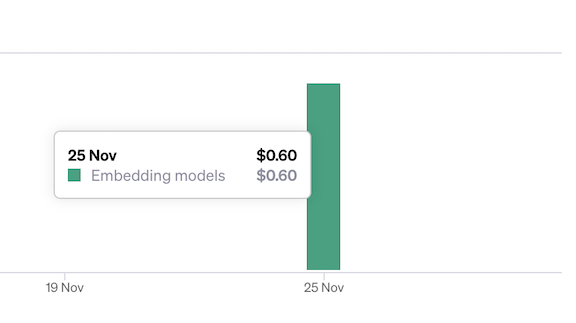)

In [59]:
get_cost(encoding, contents)

Total Tokens: 5958345

Total Cost: $0.60

0.5958

<div>
    <img src="https://d1tlzifd8jdoy4.cloudfront.net/wp-content/uploads/2023/03/eyecatch-llamdaindex.png" width="200"/>
</div>

### Get Embeddings (using LlamaIndex)

To handle this job without using LlamaIndex is no small feat, you would have to account for the various rate limits that OpenAI has in place, which change depending on your pricing tier and the actions that you want to perform.  There are requests per minute (RPM), requests per day (RPD) and tokens per minute (TPM) rate limits to consider.  If you are at pricing Tier 1, for example, you'd have a TPM limit of 1,000,000 tokens per minute, so this job will take at least six minutes to complete.  See the [OpenAI Rate Limits page](https://platform.openai.com/docs/guides/rate-limits?context=tier-one) for additional detail. Thankfully, LlamaIndex handles all of these considerations under the hood.  I was able to complete this task in 2.5 minutes (your time may vary depending on your pricing tier).

In [60]:
from llama_index import ServiceContext
from llama_index.embeddings import OpenAIEmbedding

In [61]:
embed_model = OpenAIEmbedding(embed_batch_size=150)
service_context = ServiceContext.from_defaults(embed_model=embed_model)

### Flatten Content
This part is very important because the `get_text_embedding_batch` method only accepts a list of strings as an arg.  This batch feature is very convenient though because it allows the user to dump their entire corpus into the function at one go and allow the code to perform all the heavy lifting.

In [62]:
#converts list of lists of text (strings) into a single list of text (strings)
flattened_content = [chunk for alist in splits for chunk in alist]

In [63]:
%%time
#get ada embeddings
ada_embs = embed_model.get_text_embedding_batch(flattened_content, show_progress=True)

Generating embeddings:   0%|          | 0/26448 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
#convert output to DataFrame to visualize and then save results as parquet
llama_df = pd.DataFrame({'text': flattened_content, 'embeddings': ada_embs})

In [ ]:
llama_df

,text,embeddings
0,You said these are dangerous times. The world ...,"[0.005960326176136732, -0.021358110010623932, ..."
1,Most of the military capacity and the cyber de...,"[0.019741147756576538, -0.04180788993835449, 0..."
2,But when I look at artificial intelligence in ...,"[0.015424976125359535, -0.024442654103040695, ..."
3,"The one thing when I look at that, that I real...","[0.008472912944853306, -0.01969771273434162, 0..."
4,I'm not particularly worried that we're on the...,"[-0.015207567252218723, -0.032511815428733826,..."
...,...,...
26443,And you've got to put up with that for yoursel...,"[-0.020832937210798264, -0.02005843073129654, ..."
26444,What's the impact you want to have on the worl...,"[-0.0050962683744728565, -0.006646464113146067..."
26445,He talks about happiness is not a test that yo...,"[-0.01625116728246212, -0.017197072505950928, ..."
26446,"Anytime this man is live, I'm trying to be the...","[-0.015187864191830158, -0.03839998319745064, ..."


In [ ]:
#save as parquet for later use
# llama_df.to_parquet('./impact_theory_ada_embs.parquet', index=False)

The remaining part of joining the text/vector pairs with the episode metadata is left as an exercise to the user.  Something to keep in mind is that the pairs are no longer chunked as episodes, so keep that in mind when joining back with episode metadata.  Also, **very important** if you want to compare the effectiveness of these embeddings against other embedding methods (`all-MiniLM-L6-v2`) make sure that you use the same `doc_ids` that you created when completing Assignment 1.3.  The `doc_ids` will be used as our term of measurement when doing Retrieval Evaluation in Notebook 3 of the course.